In [1]:
import sys
import cv2
import time
import logging
import numpy as np
import pandas as pd
import math
from tqdm import tqdm
import ipywidgets as widgets
import multiprocessing as mp 
from tensorflow.keras.models import load_model

import csv

import ast

In [2]:
##Specify all the file paths for required files
# Specify the paths for the 2 files
protoFile = "pose_deploy_linevec.prototxt"

weightsFile = "pose_iter_440000.caffemodel"
# Read the network into Memory

#### Load these two files for first onboarding. Subsequently, comment out these two lines and use 
#### files in 'Section A'
# df=pd.read_csv('data_augmented.csv') 
# df_label=pd.read_csv('PersonLabel_augmented.csv')
####
df=pd.read_csv('data_augmented.csv') 
y=pd.read_csv('PersonLabel_augmented.csv').values.tolist()

temparray=[]
for rowdata in y:
    #print(rowdata)
    rowdata=ast.literal_eval(rowdata[0])
    temparray.append(rowdata)
temparray=np.array(temparray)
y=temparray
####Section A ####
####Use this section after first case of onboarding.
####This is because first case must be built on original data files 'data_augmented' and 'PersonLabel_augmented'
####which are both original data set. This is to avoid contaminating the orignal set. 
#df=pd.read_csv('data_augmented_onboarded.csv', header=None)
#y=pd.DataFrame(pd.read_csv('PersonLabel_augmented_onboarded.csv',header=None).values.tolist()).values

####

modelFilePath='siamesenetwork.h5'


net = cv2.dnn.readNetFromCaffe(protoFile, weightsFile)

In [3]:
print(df.shape, y.shape)

(792, 95) (792, 44)


In [4]:
# import ast
# generic = lambda x: ast.literal_eval(x)
# conv = {'0': generic,
# }
# dftest = pd.read_csv('PersonLabel_augmented.csv').values.tolist()#, converters=conv)
# # dftest.shape

# temparray=[]
# for rowdata in dftest:
#     #print(rowdata)
#     rowdata=ast.literal_eval(rowdata[0])
#     temparray.append(rowdata)
# temparray=np.array(temparray)
# print(temparray.shape, temparray)
# #print(dftest)

In [5]:
def flattenList(inputList):
    lst=[]
    
    for i in inputList:
        #print(i)
        if i is None:
            lst.append(0)
            lst.append(0)
        else:
            try:
                for k in i:
                    lst.append(k)
            except:
                lst.append(i)

    return lst

# a=[(445, 203), (528, 500), (278, 516), None, None, (806, 485), (862, 704), None, None, None, None, None, None, None, (417, 140), (528, 140), None, (640, 234)]

# print(flattenList(a),len(flattenList(a))) 
# x=flattenList(a)
# process_joints(x)

In [6]:
nPoints = 18
POSE_PAIRS = [ [1,0],[1,2],[1,5],[2,3],[3,4],[5,6],[6,7],[1,8],[8,9],[9,10],[1,11],[11,12],[12,13],[0,14],[0,15],[14,16],[15,17]]

inWidth = 368     #Here we supply the spatial size that the Convolutional Neural Network expects.
inHeight = 368    #Here we supply the spatial size that the Convolutional Neural Network expects.
threshold = 0.1

#body_pose_list=[]
count=10
num_frames_no_kp_detected=count



In [7]:

def startcapture():
    print('Starting In 3 Seconds')
    #time.sleep(3)
    body_pose_list=[]
    cap = cv2.VideoCapture(0)
    while True:
        try:

            #print(cap.isOpened())
            #cap.set(3,1280)
            #cap.set(4,1024)
            #time.sleep(2)
            #cap.set(15, -8.0)
            t = time.time()
            points = []
            #cv2.waitKey(5)
            
            hasFrame, frame = cap.read()
            frameCopy = np.copy(frame)
            
            
#             cv2.imshow('tf-pose-estimation result', frame)
#             cv2.waitKey(5)
            


            frameWidth = frame.shape[1]
            frameHeight = frame.shape[0]

            inpBlob = cv2.dnn.blobFromImage(frame, 1.0 / 255, (inWidth, inHeight),(0, 0, 0), swapRB=False, crop=False)
            net.setInput(inpBlob)
            output = net.forward()
            
            H = output.shape[2] # Empty list to store the detected keypoints
            W = output.shape[3] # Empty list to store the detected keypoints

            for i in range(nPoints):
                # confidence map of corresponding body's part.
                probMap = output[0, i, :, :]

                # Find global maxima of the probMap.
                minVal, prob, minLoc, point = cv2.minMaxLoc(probMap)
                #print(minVal, prob, minLoc, point)
                # Scale the point to fit on the original image
                x = (frameWidth * point[0]) / W
                y = (frameHeight * point[1]) / H
                
                
                if prob > threshold : 
                    cv2.circle(frameCopy, (int(x), int(y)), 8, (0, 255, 255), thickness=-1, lineType=cv2.FILLED)
                    cv2.putText(frameCopy, "{}".format(i), (int(x), int(y)), cv2.FONT_HERSHEY_SIMPLEX, 1, (0, 0, 255), 2, lineType=cv2.LINE_AA)

                    # Add the point to the list if the probability is greater than the threshold
                    points.append((int(x), int(y)))
                else :
                    points.append(None)
                
            print(points)
            
                # Draw Skeleton
            for pair in POSE_PAIRS:
                partA = pair[0]
                partB = pair[1]

                if points[partA] and points[partB]:
                    cv2.line(frame, points[partA], points[partB], (0, 255, 255), 3, lineType=cv2.LINE_AA)
                    cv2.circle(frame, points[partA], 8, (0, 0, 255), thickness=-1, lineType=cv2.FILLED)
                    cv2.circle(frame, points[partB], 8, (0, 0, 255), thickness=-1, lineType=cv2.FILLED)


            cv2.putText(frame, "time taken = {:.2f} sec".format(time.time() - t), (50, 50), cv2.FONT_HERSHEY_COMPLEX, 1, (255, 50, 0), 2, lineType=cv2.LINE_AA)
            # cv2.putText(frame, "OpenPose using OpenCV", (50, 50), cv2.FONT_HERSHEY_COMPLEX, 1, (255, 50, 0), 2, lineType=cv2.LINE_AA)
            # cv2.imshow('Output-Keypoints', frameCopy)
            #cv2.imshow('Output-Skeleton', frame)
            
            if all([i==None for i in points]) or all([i==0 for i in points]):
                cv2.putText(frame, "Auto Shut Down In :{}".format(num_frames_no_kp_detected), (300, 300), cv2.FONT_HERSHEY_COMPLEX, 2, (0, 0, 255), 2, lineType=cv2.LINE_AA)
                num_frames_no_kp_detected-=1
                #print(num_frames_no_kp_detected)
            else:
                num_frames_no_kp_detected=count
                #print('test')

            
            cv2.putText(frame, "FPS: %f" % (1.0 / (time.time() - t)), (50, 300),
                        cv2.FONT_HERSHEY_SIMPLEX, 1, (0, 255, 0), 2)
            
            
            cv2.imshow('tf-pose-estimation result', frame)
            cv2.waitKey(5)
#             time.sleep(1)


            temp_kp_List=flattenList(points)
            body_pose_list.append(temp_kp_List)
            #normalized_kp_list=process_joints(temp_kp_List)
            #body_pose_list.append(normalized_kp_list)
            print(body_pose_list)


#             if cv2.waitKey(30) & 0xFF == ord('q'):
#                     print('Key Exit')
#                     break
            
            #if not hasFrame:
            #    break
       
            if (all([i==0 for i in points]) 
                or all([i==None for i in points])
                and num_frames_no_kp_detected<1):
                break
            if len(body_pose_list)>95: #set max frames to capture
                break
     

            

        except :
            print('Exception2')
            break
   
    cap.release()
    cv2.waitKey(2)
    cv2.destroyAllWindows()
    cv2.waitKey(2)
    return body_pose_list


def startcapture():
    body_pose_list=[]
    print('Starting In 3 Seconds')
    time.sleep(3)
    cap = cv2.VideoCapture(0)
    t = time.time()
    
    while True:
        
            try:

                #cap = cv2.VideoCapture(0)
                #cap.set(3,1280)
                #cap.set(4,1024)
                #time.sleep(2)
                #cap.set(15, -8.0)

                points = []

                hasFrame, frame = cap.read()
                frameCopy = np.copy(frame)
                #cv2.imshow('tf-pose-estimation result', frame)
                #cv2.waitKey(5)
                



                frameWidth = frame.shape[1]
                frameHeight = frame.shape[0]

                inpBlob = cv2.dnn.blobFromImage(frame, 1.0 / 255, (inWidth, inHeight),(0, 0, 0), swapRB=False, crop=False)
                net.setInput(inpBlob)
                output = net.forward()

                H = output.shape[2] # Empty list to store the detected keypoints
                W = output.shape[3] # Empty list to store the detected keypoints

                for i in range(nPoints):
                    # confidence map of corresponding body's part.
                    probMap = output[0, i, :, :]

                    # Find global maxima of the probMap.
                    minVal, prob, minLoc, point = cv2.minMaxLoc(probMap)

                    # Scale the point to fit on the original image
                    x = (frameWidth * point[0]) / W
                    y = (frameHeight * point[1]) / H

                    if prob > threshold : 
                        cv2.circle(frameCopy, (int(x), int(y)), 8, (0, 255, 255), thickness=-1, lineType=cv2.FILLED)
                        cv2.putText(frameCopy, "{}".format(i), (int(x), int(y)), cv2.FONT_HERSHEY_SIMPLEX, 1, (0, 0, 255), 2, lineType=cv2.LINE_AA)

                        # Add the point to the list if the probability is greater than the threshold
                        points.append((int(x), int(y)))
                    else :
                        points.append(None)

                    # Draw Skeleton
                for pair in POSE_PAIRS:
                    partA = pair[0]
                    partB = pair[1]

                    if points[partA] and points[partB]:
                        cv2.line(frame, points[partA], points[partB], (0, 255, 255), 3, lineType=cv2.LINE_AA)
                        cv2.circle(frame, points[partA], 8, (0, 0, 255), thickness=-1, lineType=cv2.FILLED)
                        cv2.circle(frame, points[partB], 8, (0, 0, 255), thickness=-1, lineType=cv2.FILLED)



                cv2.putText(frame, "time taken = {:.2f} sec".format(time.time() - t), (50, 50), cv2.FONT_HERSHEY_COMPLEX, 1, (255, 50, 0), 2, lineType=cv2.LINE_AA)
                # cv2.putText(frame, "OpenPose using OpenCV", (50, 50), cv2.FONT_HERSHEY_COMPLEX, 1, (255, 50, 0), 2, lineType=cv2.LINE_AA)
                # cv2.imshow('Output-Keypoints', frameCopy)
                #cv2.imshow('Output-Skeleton', frame)

                if all([i==None for i in points]):
                    cv2.putText(frame, "Auto Shut Down In :{}".format(num_frames_no_kp_detected), (300, 300), cv2.FONT_HERSHEY_COMPLEX, 2, (255, 50, 0), 2, lineType=cv2.LINE_AA)
                    num_frames_no_kp_detected-=1
                else:
                    num_frames_no_kp_detected=count

                cv2.putText(frame, "FPS: %f" % (1.0 / (time.time() - t)), (50, 300),
                            cv2.FONT_HERSHEY_SIMPLEX, 1, (0, 255, 0), 2)
                cv2.imshow('tf-pose-estimation result', frame)
                cv2.waitKey(1)
                time.sleep(0.1)



                temp_kp_List=flattenList(points)
                body_pose_list.append(temp_kp_List)
                #normalized_kp_list=process_joints(temp_kp_List)
                #body_pose_list.append(normalized_kp_list)
                print(body_pose_list)

                if cv2.waitKey(2) & 0xFF == ord('q'):
                        break

                #if not hasFrame:
                #    break
                if all([i==None for i in points]) and num_frames_no_kp_detected<1:
                    break
                if len(body_pose_list)>95: #set max frames to capture
                    break

            except :
                break
   
    cap.release()
    cv2.waitKey(2)
    cv2.destroyAllWindows()
    cv2.waitKey(2)
    return body_pose_list

## Capture New Person's KeyPoints.

In [8]:
body_pose_list=startcapture()

Starting In 3 Seconds
[None, None, None, (779, 375), (834, 406), None, None, None, None, None, None, None, None, None, None, None, None, None]
[[0, 0, 0, 0, 0, 0, 779, 375, 834, 406, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]]
[None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None]
[[0, 0, 0, 0, 0, 0, 779, 375, 834, 406, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0], [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]]
[None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None]
[[0, 0, 0, 0, 0, 0, 779, 375, 834, 406, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0], [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0], [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0

[(333, 250), (361, 266), (361, 266), None, None, (361, 266), (361, 328), (361, 375), (361, 360), (333, 422), (361, 485), (361, 375), (361, 438), (389, 500), None, (333, 234), (361, 234), (333, 234)]
[[0, 0, 0, 0, 0, 0, 779, 375, 834, 406, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0], [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0], [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0], [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0], [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0], [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0], [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0], [973, 234, 1001, 266, 

[None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None]
[[0, 0, 0, 0, 0, 0, 779, 375, 834, 406, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0], [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0], [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0], [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0], [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0], [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0], [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0], [973, 234, 1001, 266, 1001, 266, 0, 0, 0, 0, 1029, 266, 1029, 328, 1001, 375, 973, 360, 973, 438, 1001, 500, 100

[None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None]
[[0, 0, 0, 0, 0, 0, 779, 375, 834, 406, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0], [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0], [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0], [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0], [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0], [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0], [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0], [973, 234, 1001, 266, 1001, 266, 0, 0, 0, 0, 1029, 266, 1029, 328, 1001, 375, 973, 360, 973, 438, 1001, 500, 100

[None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None]
[[0, 0, 0, 0, 0, 0, 779, 375, 834, 406, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0], [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0], [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0], [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0], [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0], [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0], [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0], [973, 234, 1001, 266, 1001, 266, 0, 0, 0, 0, 1029, 266, 1029, 328, 1001, 375, 973, 360, 973, 438, 1001, 500, 100

In [9]:
def compute_length(x1, y1, x2, y2):
    return math.sqrt((x1-x2)*(x1-x2) + (y1-y2)*(y1-y2))

def process_joints(x):

    r = [0] * 36

    refx = 0
    refy = 0
    reflength = 1   
    

    if x[2] != 0 or x[3] != 0:         #determine if neck position, which is the index 2 and index 3
        refx = x[2]                # use the neck X, Y
       # print('refx:',refx)
        refy = x[3]
       # print('refy:',refy)
    elif (x[4] != 0 or x[5] != 0) and (x[10] != 0 or x[11] != 0):   #using shoulder position from to derive an estimate to neck position.
        refx = (x[4] + x[10]) / 2  # estimate the neck X, Y from the mid point
        refy = (x[5] + x[11]) / 2  # of the left/right shoulder  
       # print('refx:',refx)
       # print('refy:',refy)

    elif (x[4] != 0 or x[5] != 0):   #estimate using only the left shoulder poin.
        refx = x[4]  # estimate from left shoulder
        refy = x[5]  # estimate from left shoulder
   
    elif (x[10] != 0 or x[11] != 0):   #estimate using only the right shoulder poin.
        refx = x[10]  # estimate from right shoulder
        refy = x[11]  # estimate from right shoulder

 
    if x[16] != 0 and x[17] != 0:             
        reflength = compute_length(x[16], x[17], refx, refy)   # neck to right hip
    elif x[22] != 0 and x[23] != 0:
        reflength = compute_length(x[22], x[23], refx, refy)   # neck to left hip 
 
    for i in range(0, 18):
        if x[i*2] !=0:
            r[i*2] = (x[i*2] - refx) / reflength
        else :
             r[i*2] = x[i*2]   #if the orignal coordinates are at 0, then just transfer to reference.
        if x[i*2 + 1] !=0:
            r[i*2 + 1] = -(x[i*2 + 1] - refy) / reflength
        else :
            r[i*2 + 1] = x[i*2 + 1]
 
    
    #print(r)
    return r

In [10]:
for eachframe in body_pose_list:
    print(eachframe)
    process_joints(eachframe)

[0, 0, 0, 0, 0, 0, 779, 375, 834, 406, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]
[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]
[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]
[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]
[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]
[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]
[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]
[973, 234, 1001, 266, 1001, 266, 0, 0, 0, 0, 1029, 266, 1029, 328, 1001, 375, 973, 360, 973, 438, 1001, 500, 1001, 375, 1001, 453, 1029, 500, 973, 234, 973, 234, 0, 0, 1001, 234]
[806, 234, 834, 266, 834, 266, 0, 0, 0, 0, 862, 26

In [11]:
normalized_body_pose_list=[process_joints(eachframe)for eachframe in body_pose_list]

bodyPoseArray=np.array(normalized_body_pose_list)
bodyPoseArray.shape
#bodyPoseArray[0:2,:]

(26, 36)

In [12]:
max_frames=95 #must set this to be same as trained model. 

#print(max_frames)
def process_detected_frames(max_frames,bodyPoseArray):
    num_frames_detected=bodyPoseArray.shape[0]
    if num_frames_detected>max_frames:
        bodyPoseArray=bodyPoseArray[0:max_frames,:]
        return bodyPoseArray
    else:
        #zeroArray=np.zeros((max_frames,36))
        zeroArray=np.zeros((max_frames,36))
        print(zeroArray.shape)
        zeroArray[:bodyPoseArray.shape[0],:bodyPoseArray.shape[1]]=bodyPoseArray
        #print(np.transpose(zeroArray).shape)
        print(zeroArray.shape)
        return zeroArray

processedData=process_detected_frames(max_frames,bodyPoseArray)
print(processedData.shape)
#processedData=processedData.reshape((1,max_frames,36))

print(processedData,'\n\n',bodyPoseArray)

#df_detected=process_detected_frames(max_frames,df) #pad the frames to fixed length or crop them

(95, 36)
(95, 36)
(95, 36)
[[0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 ...
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]] 

 [[ 0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00
   0.00000000e+00  0.00000000e+00  7.79000000e+02 -3.75000000e+02
   8.34000000e+02 -4.06000000e+02  0.00000000e+00  0.00000000e+00
   0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00
   0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00
   0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00
   0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00
   0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00
   0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00]
 [ 0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00
   0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00
   0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00
   0.00000000e+00  0.

In [13]:
processedData_list=[]
for i,cell in enumerate(processedData):
    processedData_list.append((i,cell))
processedData_df=pd.DataFrame(processedData_list)
display(processedData_df)
processedData_df.drop(columns=[0],axis=1, inplace=True)
processedData_df=processedData_df.T

,0,1
0,0,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 779.0, -375.0, ..."
1,1,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."
2,2,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."
3,3,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."
4,4,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."
...,...,...
90,90,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."
91,91,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."
92,92,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."
93,93,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."


In [14]:
processedData_df.reset_index(drop=True,inplace=True)

In [15]:
processedData_df.head()

,0,1,2,3,4,5,6,7,8,9,...,85,86,87,88,89,90,91,92,93,94
0,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 779.0, -375.0, ...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[-0.28547658660016495, 0.32625895611447425, 0....","[-0.2978723404255319, 0.3404255319148936, 0.0,...","[0.0, 0.19384329711595039, 0.0, 0.0, -0.327110...",...,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."


In [16]:
stop=df.shape[1]
processedData_df.columns=[str(i) for i in list(range(0,stop))]
processedData_df

,0,1,2,3,4,5,6,7,8,9,...,85,86,87,88,89,90,91,92,93,94
0,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 779.0, -375.0, ...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[-0.28547658660016495, 0.32625895611447425, 0....","[-0.2978723404255319, 0.3404255319148936, 0.0,...","[0.0, 0.19384329711595039, 0.0, 0.0, -0.327110...",...,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."


In [17]:
processedData_df.shape

(1, 95)

In [18]:
df.shape

(792, 95)

In [19]:
#df=df.append(processedData_df,ignore_index=True)
#df=pd.concat([df,processedData_df], axis=0)

In [20]:
df.head()

,0,1,2,3,4,5,6,7,8,9,...,85,86,87,88,89,90,91,92,93,94
0,"[0.0, 0.0, 0.0, 0.0, 0.0002448784087915845, 0....","[0.17522129060731412, 0.2874729202431497, 0.0,...","[0.275779359207068, 0.26508140219964754, 0.0, ...","[0.2387925360778001, 0.3069714788637996, 0.0, ...","[0.20456744185837544, 0.30737914614479034, 0.0...","[0.24075421008753317, 0.35584099533804675, 0.0...","[0.25804888554524974, 0.31737329156146776, 0.0...","[0.17495590964359647, 0.2840891447979197, 0.0,...","[0.18076530371415564, 0.2767317541279658, 0.0,...","[0.20757447598040882, 0.28529764968514537, 0.0...",...,"[0.0, 0, 0.0, 0, 0.0, 0, 0.0, 0, 0.0, 0, 0.0, ...","[0.0, 0, 0.0, 0, 0.0, 0, 0.0, 0, 0.0, 0, 0.0, ...","[0.0, 0, 0.0, 0, 0.0, 0, 0.0, 0, 0.0, 0, 0.0, ...","[0.0, 0, 0.0, 0, 0.0, 0, 0.0, 0, 0.0, 0, 0.0, ...","[0.0, 0, 0.0, 0, 0.0, 0, 0.0, 0, 0.0, 0, 0.0, ...","[0.0, 0, 0.0, 0, 0.0, 0, 0.0, 0, 0.0, 0, 0.0, ...","[0.0, 0, 0.0, 0, 0.0, 0, 0.0, 0, 0.0, 0, 0.0, ...","[0.0, 0, 0.0, 0, 0.0, 0, 0.0, 0, 0.0, 0, 0.0, ...","[0.0, 0, 0.0, 0, 0.0, 0, 0.0, 0, 0.0, 0, 0.0, ...","[0.0, 0, 0.0, 0, 0.0, 0, 0.0, 0, 0.0, 0, 0.0, ..."
1,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[15.664500000000004, 54.947, 0.0, 0.0, -35.286...","[0.1892188610206415, 0.3153112205074499, 0.0, ...","[0.17590752580270297, 0.35160739176797423, 0.0...","[0.1516448199485351, 0.25661458076219495, 0.0,...","[0.17482013733554239, 0.3840012489363702, 0.0,...","[0.241048098836105, 0.3673435076695727, 0.0, 0...","[0.1949698113084814, 0.3785348592735734, 0.0, ...","[0.17591500264396362, 0.3643027559189545, 0.0,...","[0.2325178599625046, 0.3884650580707508, 0.0, ...",...,"[0.0, 0, 0.0, 0, 0.0, 0, 0.0, 0, 0.0, 0, 0.0, ...","[0.0, 0, 0.0, 0, 0.0, 0, 0.0, 0, 0.0, 0, 0.0, ...","[0.0, 0, 0.0, 0, 0.0, 0, 0.0, 0, 0.0, 0, 0.0, ...","[0.0, 0, 0.0, 0, 0.0, 0, 0.0, 0, 0.0, 0, 0.0, ...","[0.0, 0, 0.0, 0, 0.0, 0, 0.0, 0, 0.0, 0, 0.0, ...","[0.0, 0, 0.0, 0, 0.0, 0, 0.0, 0, 0.0, 0, 0.0, ...","[0.0, 0, 0.0, 0, 0.0, 0, 0.0, 0, 0.0, 0, 0.0, ...","[0.0, 0, 0.0, 0, 0.0, 0, 0.0, 0, 0.0, 0, 0.0, ...","[0.0, 0, 0.0, 0, 0.0, 0, 0.0, 0, 0.0, 0, 0.0, ...","[0.0, 0, 0.0, 0, 0.0, 0, 0.0, 0, 0.0, 0, 0.0, ..."
2,"[0.10257452267647307, 0.4246603163580588, 0.0,...","[0.18649193357184113, 0.4049084879972422, 0.0,...","[0.12301277212487861, 0.3843246239650838, 0.0,...","[0.23457380548929446, 0.37529098332682614, 0.0...","[0.2153002410793222, 0.41629479220004223, 0.0,...","[0.1597617665370772, 0.4953726490046505, 0.0, ...","[0.12137449338893704, 0.43918605708618, 0.0, 0...","[0.1713245910520363, 0.399893518878473, 0.0, 0...","[0.19694061833561738, 0.4239198807069571, 0.0,...","[0.17590876977087863, 0.36691298569346836, 0.0...",...,"[0.0, 0, 0.0, 0, 0.0, 0, 0.0, 0, 0.0, 0, 0.0, ...","[0.0, 0, 0.0, 0, 0.0, 0, 0.0, 0, 0.0, 0, 0.0, ...","[0.0, 0, 0.0, 0, 0.0, 0, 0.0, 0, 0.0, 0, 0.0, ...","[0.0, 0, 0.0, 0, 0.0, 0, 0.0, 0, 0.0, 0, 0.0, ...","[0.0, 0, 0.0, 0, 0.0, 0, 0.0, 0, 0.0, 0, 0.0, ...","[0.0, 0, 0.0, 0, 0.0, 0, 0.0, 0, 0.0, 0, 0.0, ...","[0.0, 0, 0.0, 0, 0.0, 0, 0.0, 0, 0.0, 0, 0.0, ...","[0.0, 0, 0.0, 0, 0.0, 0, 0.0, 0, 0.0, 0, 0.0, ...","[0.0, 0, 0.0, 0, 0.0, 0, 0.0, 0, 0.0, 0, 0.0, ...","[0.0, 0, 0.0, 0, 0.0, 0, 0.0, 0, 0.0, 0, 0.0, ..."
3,"[0.13302203273083382, 0.4700551967384218, 0.0,...","[0.09421312141340309, 0.45309470504857746, 0.0...","[0.12267374247517351, 0.39958600151310014, 0.0...","[0.10978048721253882, 0.39088555163453004, 0.0...","[0.09430960990988571, 0.37528561218620254, 0.0...","[0.14218348575425158, 0.4118172561654683, 0.0,...","[0.18382754309201266, 0.38373236086954554, 0.0...","[0.22785302668489213, 0.37481173403621754, 0.0...","[0.20807959053145783, 0.38680371184141904, 0.0...","[0.1861201892271649, 0.40442920401173105, 0.0,...",...,"[0.0, 0, 0.0, 0, 0.0, 0, 0.0, 0, 0.0, 0, 0.0, ...","[0.0, 0, 0.0, 0, 0.0, 0, 0.0, 0, 0.0, 0, 0.0, ...","[0.0, 0, 0.0, 0, 0.0, 0, 0.0, 0, 0.0, 0, 0.0, ...","[0.0, 0, 0.0, 0, 0.0, 0, 0.0, 0, 0.0, 0, 0.0, ...","[0.0, 0, 0.0, 0, 0.0, 0, 0.0, 0, 0.0, 0, 0.0, ...","[0.0, 0, 0.0, 0, 0.0

In [21]:
df.shape

(792, 95)

In [22]:
# import ast

# NewPersonLabel=len(ast.literal_eval(df_label.loc[0].tolist()[0]))+1
# num_of_classes=NewPersonLabel



In [23]:
# df_label.head()

In [24]:
# import ast

# NewPersonLabel=len(ast.literal_eval(df_label.loc[0].tolist()[0]))+1
# num_of_classes=NewPersonLabel





### For Testing. Uncomment Cell Below For Testing and Deugging.

In [25]:
# #for testing. Test case is for same person. Expected prediction should near to zero. 
# model=load_model(modelFilePath,compile=False)
# max_frames=df.shape[1]
# temp1=x[-1,:max_frames,:]
# temp2=x[-1,:max_frames,:]
# temp1=temp1.reshape((1,max_frames,36))
# temp2=temp2.reshape((1,max_frames,36))
# print(temp1.shape)

# model.predict([temp1,temp2])

## Add or Remover Person Label

In [26]:

# NewPersonLabel=len(ast.literal_eval(df_label.loc[0].tolist()[0]))+1
# num_of_classes=NewPersonLabel

def add_removePersonLabel(df_label,df,processedData_df=None): #True label for add
    input1= input('Add or Remove Person?\n'\
         'Type "a" to add.\n'\
         'Type "r" to remove.')
    y_class_list=[i+1 for i in np.argmax(df_label,axis=1)] #one hot encoding index 0 represent Person ID 1.
    
    #print(y_class_list)
    y = []
    y_onehot=[]
    num_of_classes=len(set(y_class_list)) #current class list
    index = 0
    if input1=='a' and num_of_classes>=44: #first 44 classes are set aside as a permanent block for testing and debugging. 
        
        print('New Person ID is :', num_of_classes+1) #Person ID starts from 1. Indexes start from 0.
        #NewPersonLabel= int(input('Provide Person ID Number To add: '))
        
        #y_class_list=y_class_list.append(num_of_classes+1) #updated class list with new Person ID.
        y_class_list.append(num_of_classes+1)
#         oneHot_newPersonID= = [0] * (len(set(y_class_list))+1)
#         oneHot_newPersonID[-1]=1
        
        if processedData_df is not None:
            print('processedData_df exist')
            df=pd.concat([df,processedData_df], axis=0)
        else:
            print('Missing Detection. Nothing Will Be Added')
            return None ,None
        
        #print(type(y_class_list), type(y_class_list_updated), type(num_of_classes), y_class_list_updated)
        for each in range(len(df)):
            #print(y_class_list)
            one_hot = [0] * (len(set(y_class_list)))
            #print(one_hot)
            if each<range(len(df))[-1]:
                one_hot[np.argmax(df_label[each])]=1
                y.append(one_hot)
            else: 
                one_hot[-1]=1
                y.append(one_hot)
        y_onehot=np.array(y)
        
        return df,y_onehot
        
        
    
    elif input1=='r' and num_of_classes>=44:
        print('Will Remove The Last Person ID. This is for testing only')
        print('Remove Class and Data For Person ID :',  y_class_list[-1])
        
        #print(len(y_class_list))
        
        index_removed_class=len(y_class_list)-1
        #print(index_removed_class)
        del y_class_list[-1]
        
        print('y_class_list after removed :',len(y_class_list))
        print(df.shape)
        
        df_dropped=df.drop([index_removed_class])
        
        print('df_dropped :',df_dropped.shape)
        
        for each in range(len(df_dropped)):
            
            one_hot = [0] * (len(set(y_class_list))+1)
            #print(one_hot)
            one_hot[np.argmax(df_label[each])]=1
            y.append(one_hot)
        
        y_onehot=np.array(y)
        return df_dropped,y_onehot

    else: 
        print("You cannot edit the first 44 class. These classes are reserved for testing and debugging.")
    
df,y_onehot=add_removePersonLabel(y,df,processedData_df)

print(df.shape,y_onehot.shape)

Add or Remove Person?
Type "a" to add.
Type "r" to remove.a
New Person ID is : 45
processedData_df exist
(793, 95) (793, 45)


In [27]:
y_onehot.shape

(793, 45)

In [28]:
#df_label=y_onehot

### Prepare the Data

In [29]:
import ast

def load_x(data):
    x = [] 
    for row in tqdm(data.itertuples(index=False)):
        x_row=[]
        for i in row:       
            #print(ast.literal_eval(i))
            try:
                x_row.append(ast.literal_eval(i))    
            except:
                x_row.append(i)
        x.append(x_row)
    x = np.array(x)
    print ("Done.")
    return x

# def load_y(data):
        
#     y = []
#     index = 0
#     for row in tqdm(data.itertuples(index=False)):
#         for i in row:
#           #print(ast.literal_eval(i))
#             try:
#                 y.append(ast.literal_eval(i))
#             except:
#                 y.append(i)
#     y = np.array(y)
#     print ("Done.")  
#     return y

x=load_x(df)
print(x.shape)

y=y_onehot
#y=load_y(df_label)
print(y.shape)

793it [00:06, 131.92it/s]


Done.
(793, 95, 36)
(793, 45)


### Test Inference On New Onboarded Person
### Version A - Faster
#### Version A is faster because of forward and backward search, and random search with threshold cutoff. 

In [30]:
%%time
min_threshold=0.7
qualifying_threshold=0.97
#max_frames=95
max_frames=95

model=load_model(modelFilePath,compile=False) #since we are making inference only, set compile to False.
x_cropped=x[:,:max_frames,:36]

def make_pairs(modelFilePath, detectedData, x,y):
    
    y_class_list=[i+1 for i in np.argmax(y,axis=1)] # need to add 1 because ID of Person start from 1, not 0.
    result=[]
    personLabel_forRow = []
    pair_class_labels=[]
    predictPairResult=[]
    
    shape=(1,max_frames,36)
    
    #result=[model.predict([detectedData.reshape(shape),i.reshape(shape)])[0][0] for i in tqdm(x_cropped)]
 
#########
    result=[]
    bestScore=None
    index_bestscore=None
    detectedData=detectedData.reshape(shape)
    
    tempListScore=[] #this store the forward search and reversed search best result
    tempListID=[]
    
#     randomRunTimes=3
#     randomRunTimes_result=[]
#     for run in range(0,randomRunTimes):
#         idx=np.random.choice(range(0,len(x_cropped)),40)
#         for i in idx:
#             score=model.predict([detectedData,x_cropped[i].reshape(shape)])[0][0]
#             randomRunTimes_result.append(score)
            
#     #print(randomRunTimes_result)
#     if max(randomRunTimes_result)<min_threshold or np.isnan(np.array(randomRunTimes_result)).all() :
#         personID='Not Detected'
#         message='No Person Detected.'
#         score='-'
#         print('Person ID Predicted : ',personID,'\t','Message : ',message,'\t',' Score:',score )
#         print('RandomSearch triggered a return. May not be the optimal result. Please try another method.')
#         return personID,score
    
    ### Implement random search if two prior did not return good result.
    randomRunTimes=6
    randomRunTimes_result=[]
    for run in range(0,randomRunTimes):
        idx=np.random.choice(range(0,len(x_cropped)),30)
        for i in idx:
            score=model.predict([detectedData,x_cropped[i].reshape(shape)])[0][0]
            randomRunTimes_result.append(score)
            
    #print(randomRunTimes_result)
    if np.isnan(np.array(randomRunTimes_result)).all() :
        personID='Not Detected'
        message='No Person Detected.'
        score='-'
        print('Person ID Predicted : ',personID,'\t','Message : ',message,'\t',' Score:',score )
        print('Most Likely No Person Detected.')
        return personID,score
    
    elif max(randomRunTimes_result)<min_threshold :
        personID='Not Detected'
        message='No Person Detected.'
        score='-'
        print('Person ID Predicted : ',personID,'\t','Message : ',message,'\t',' Score:',score )
        print('RandomSearch triggered a return. May not be the optimal result. Trying another search method.')
        #return personID,score  
    
    
    ### to implement forward and backward search need to prepare a serch index.
    search_index=len(x_cropped)//10
    
    #Forward Search
    for i,row in enumerate(tqdm(x_cropped[:search_index])):
        #print(type(row), row.shape)
        score=model.predict([detectedData,row.reshape(shape)])[0][0]
        if score>qualifying_threshold:
                #print(i, y_class_list[i], y_class_list)
                tempListScore.append( score)
                print(i)
                tempListID.append(y_class_list[i])
                break
                
#                 personID=y_class_list[i]
#                 message='This Person Is Authorized To Enter'
#                 print('Person ID Predicted : ',y_class_list[i],'\t','Message : ',message,'\t',' Score:',score )
#                 return personID, score
#         else:
#             result.append(score)

    ###Backward Search
    
    for i,row in reversed(list(enumerate(tqdm(x_cropped[:])))):
        #print(type(row), row.shape)
        score=model.predict([detectedData,row.reshape(shape)])[0][0]
        if score is not None:
            if score>qualifying_threshold:
                    tempListScore.append( score)
                    print(score)
                    #y_class_list.reverse()
                    tempListID.append(y_class_list[i])
                    break
                    print(i, y_class_list[i], y_class_list)
                    personID=y_class_list[i]
                    message='This Person Is Authorized To Enter'
                    print('Person ID Predicted : ',y_class_list[i],'\t','Message : ',message,'\t',' Score:',score )
                    return personID, score
        else:
            score=0
            result.append(score)

    print(tempListScore)

    if tempListScore:
        bestScore=max(tempListScore)
        BestScoreIndex=tempListScore.index(max(tempListScore))
        personID=tempListID[BestScoreIndex]

        message='This Person Is Authorized To Enter'
        print('Person ID Predicted : ',personID,'\t','Message : ',message,'\t',' Score:',bestScore )
        return personID,bestScore

    else:
        print('No Result. Repeat Capture Again.')
        return None,None
    

    
    

############    
#     detectedData=detectedData.reshape(shape)
#     for idxA in tqdm(range(len(x))):
        
#         rowData=x[idxA]
#         rowData=rowData[:max_frames,:36]
#         rowData=rowData.reshape((1,max_frames,36))
        
        
#         #print(rowData.shape, detectedData.shape)  
        
#         predictedResult=(model.predict([detectedData,rowData]))[0][0]
#         #print(type(predictedResult))
#         result.append(predictedResult)
    
#         #print(predictedResult)
    
    ##bestResult_rowIndex=max(zip(result,range(len(result))))[1]  
                                            #uncomment above line to tune for threshold.
                                            #to use, comment out next line. 
                                            #take some random web cam video and run prediction.
                                            #the result the set he benchmark for min threshold.
                                            #any prediction above threshold is positive
    ##bestResult_rowIndex=min(zip(result,range(len(result))))[1]  #Use for constrastive loss.
    ##print(result)
#     bestResult_rowIndex=result.index(max(result))
#     print('bestResult_rowIndex', bestResult_rowIndex)
#     ##bestResult_rowIndex=max(zip(result,range(len(result))))[1]
#     dissimilarscore=result[bestResult_rowIndex]
#     ##print(type(confidence))
#     predictedClass=y_class_list[bestResult_rowIndex]
    
#     if np.isnan(dissimilarscore):
#         personID='Not Detected'
#         message='No Person Detected.'
#     elif dissimilarscore>=threshold:    #need to change inequality sign for constrastive loss.
#         personID=predictedClass
#         message='This Person Is Authorized To Enter'
#     elif dissimilarscore<threshold:    #need to change inequality sign for constrastive loss.
#         personID='A Person Detected'
#         message='NOT AUTHORIZED. DO NOT ENTER!'
    
#     print('Person ID Predicted : ',personID,'\t','Message : ',message,'\t',' Score:',dissimilarscore )
#     return predictedClass, result

        
predictedClass,result=make_pairs(modelFilePath,processedData,x,y)        


#predictedClass,result=make_pairs(modelFilePath,zeroArray,x,y)  #use for testing.       





100%|██████████| 793/793 [00:00<00:00, 1009127.15it/s]

54
0.9998803
[0.9721243, 0.9998803]
Person ID Predicted :  45 	 Message :  This Person Is Authorized To Enter 	  Score: 0.9998803
CPU times: user 13.3 s, sys: 1.04 s, total: 14.3 s
Wall time: 9.98 s


### Version -Slower


In [31]:
%%time
min_threshold=0.7
qualifying_threshold=0.97
#max_frames=95
max_frames=95

model=load_model(modelFilePath,compile=False) #since we are making inference only, set compile to False.
x_cropped=x[:,:max_frames,:36]

def make_pairs(modelFilePath, detectedData, x,y):
    
    y_class_list=[i+1 for i in np.argmax(y,axis=1)] # need to add 1 because ID of Person start from 1, not 0.
    result=[]
    personLabel_forRow = []
    pair_class_labels=[]
    predictPairResult=[]
    
    shape=(1,max_frames,36)
    
    #result=[model.predict([detectedData.reshape(shape),i.reshape(shape)])[0][0] for i in tqdm(x_cropped)]
 
# #########
#     result=[]
#     bestScore=None
#     index_bestscore=None
#     detectedData=detectedData.reshape(shape)
    
#     randomRunTimes=3
#     randomRunTimes_result=[]
#     for run in range(0,randomRunTimes):
#         idx=np.random.choice(range(0,len(x_cropped)),30)
#         for i in idx:
#             score=model.predict([detectedData,x_cropped[i].reshape(shape)])[0][0]
#             randomRunTimes_result.append(score)
#     if max(randomRunTimes_result)<0.7 or np.isnan(np.array(randomRunTimes_result)).all() :
#         personID='Not Detected'
#         message='No Person Detected.'
#         score='-'
#         print('Person ID Predicted : ',personID,'\t','Message : ',message,'\t',' Score:',score )
#         return personID,score
    
#     for i,row in enumerate(tqdm(x_cropped)):
#         #print(type(row), row.shape)
#         score=model.predict([detectedData,row.reshape(shape)])[0][0]
#         if score>qualifying_threshold:
#                 #print(i, y_class_list[i], y_class_list)
#                 personID=y_class_list[i]
#                 message='This Person Is Authorized To Enter'
#                 print('Person ID Predicted : ',y_class_list[i],'\t','Message : ',message,'\t',' Score:',score )
#                 return personID, score
#         else:
#             result.append(score)
    
# ############    
    detectedData=detectedData.reshape(shape)
    for idxA in tqdm(range(len(x))):
        
        rowData=x[idxA]
        rowData=rowData[:max_frames,:36]
        rowData=rowData.reshape((1,max_frames,36))
        
        
        #print(rowData.shape, detectedData.shape)  
        
        predictedResult=(model.predict([detectedData,rowData]))[0][0]
        #print(type(predictedResult))
        result.append(predictedResult)
    
        #print(predictedResult)
    
    ##bestResult_rowIndex=max(zip(result,range(len(result))))[1]  
                                            #uncomment above line to tune for threshold.
                                            #to use, comment out next line. 
                                            #take some random web cam video and run prediction.
                                            #the result the set he benchmark for min threshold.
                                            #any prediction above threshold is positive
    ##bestResult_rowIndex=min(zip(result,range(len(result))))[1]  #Use for constrastive loss.
    ##print(result)
    bestResult_rowIndex=result.index(max(result))
    print('bestResult_rowIndex', bestResult_rowIndex)
    ##bestResult_rowIndex=max(zip(result,range(len(result))))[1]
    dissimilarscore=result[bestResult_rowIndex]
    ##print(type(confidence))
    predictedClass=y_class_list[bestResult_rowIndex]
    
    if np.isnan(dissimilarscore):
        personID='Not Detected'
        message='No Person Detected.'
    elif dissimilarscore>=threshold:    #need to change inequality sign for constrastive loss.
        personID=predictedClass
        message='This Person Is Authorized To Enter'
    elif dissimilarscore<threshold:    #need to change inequality sign for constrastive loss.
        personID='A Person Detected'
        message='NOT AUTHORIZED. DO NOT ENTER!'
    
    print('Person ID Predicted : ',personID,'\t','Message : ',message,'\t',' Score:',dissimilarscore )
    return predictedClass, result

        
predictedClass,result=make_pairs(modelFilePath,processedData,x,y)        


#predictedClass,result=make_pairs(modelFilePath,zeroArray,x,y)  #use for testing.       





100%|██████████| 793/793 [00:28<00:00, 28.09it/s]

bestResult_rowIndex 792
Person ID Predicted :  45 	 Message :  This Person Is Authorized To Enter 	  Score: 0.9998803
CPU times: user 39.6 s, sys: 2.96 s, total: 42.6 s
Wall time: 29.3 s


<BarContainer object of 793 artists>

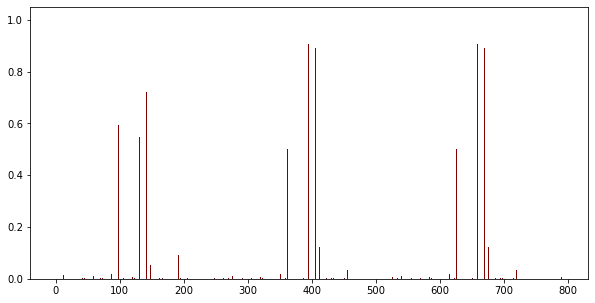

In [32]:
import matplotlib.pyplot as plt 
fig = plt.figure(figsize = (10, 5)) 
plt.bar(list(range(len(result))),result, color ='maroon',  
        width = 0.4) 

### After confirming prediction is correct, we write to these files: 
#### data_augmented_onboarded.csv
#### PersonLabel_augmented_onboarded.csv'


In [33]:
x.shape

(793, 95, 36)

In [34]:
y.shape

(793, 45)

Writing a 3D Numpy array to a CSV file
https://stackoverflow.com/questions/50459119/writing-a-3d-numpy-array-to-a-csv-file



In [35]:
fil_name1 = 'data_augmented_onboarded'

x_data = x.tolist()
with open(fil_name1+'.csv', 'w', newline='') as csvfile:
    writer = csv.writer(csvfile, delimiter=',')
    writer.writerows(x_data)

In [36]:
fil_name2 = 'PersonLabel_augmented_onboarded'
np.savetxt(fil_name2+'.csv',y,delimiter=",")


In [37]:

#Testing if csv is correctly loadinto dataFrame
dftest=pd.read_csv('data_augmented_onboarded.csv', header=None)

In [38]:
dftest.shape

(793, 95)

In [39]:
#Testing if csv is correctly loadinto numpy array


testdf=pd.DataFrame(pd.read_csv('PersonLabel_augmented_onboarded.csv',header=None).values.tolist()).values

print(testdf.shape, type(testdf))

(793, 45) <class 'numpy.ndarray'>
